# Importing Libraries and Downloading Data

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

#### Download data

In [2]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Dataset Preprocessing

In [3]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [4]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

#### Number of neurons in the input and output layers

In [5]:
input_nodes = num_features
output_nodes = num_classes

#### Class names

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Components of the Neural Network Model

#### Activation functions and their derivatives

In [7]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [8]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    '''Function to initialise weights, biases and velocities/previous updates of the NN

    Parameters
    ----------
    layer_dims: list
        list of number of neurons per layer specifying layer dimensions in the format [#input_features,#hiddenunits...#hiddenunits,#outputclasses]

    init_mode: string
        initialisation mode, default-"xavier"

    Returns
    -------
    params: dict
        contains weights and biases. eg params[W1] is weight for layer 1

    previous updates: dict
        previous updates initialisation. This is used for different perposes for different optimisers.

    '''
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [9]:
def forward_propagate(X, params, activation_f):
    '''Function to forward propagate a minibatch of data once through the NN

    Parameters
    ----------
    X: numpy array
        data in (features,batch_size) format

    params: dict
        W and b of the NN

    activation_f: string
        activation function to be used except the output layer

    Returns
    -------
    output: numpy array
        contains the output probabilities for each class and each data sample after 1 pass
    A: numpy array
        contains all post-activations
    Z: numpy array
        contsins all pre-activations

    '''
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [10]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    '''Function to calculate gradients for a minibatch of data once through the NN through backpropagation

    Parameters
    ----------
    y_hat: numpy array
        output from forward propagation/ class probabilities

    y: numpy array
        actual class labels
     
    A: numpy array
        post-activations

    Z: numpy array
        pre-activations   

    params: dict
        contains W and b on the NN   

    activation_f: string
        activation function to be used except the output layer

    batch_size: int
        mini-batch-size

    loss: string
        loss function (MSE/Categorical crossentropy)

    lamb: float
        L2 regularisation lambda

    Returns
    -------
    gradients: dict
        gradients wrt weights and biases

    '''
    L = len(params)//2
    gradients = {}
    
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [11]:
def update_params_sgd(parameters,grads,learning_rate):
    ''' Update W and b of the NN according to sgd updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    Returns
    -------
    parameters: dict
        updated NN parameters

    '''
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    ''' Update W and b of the NN according to momentum updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    previous_updates: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        previous_updates[Wi] = beta*previous_updates[Wi] + (1-beta)*gradient[dWi]

    Returns
    -------
    parameters: dict
        updated NN parameters

    previous updates: dict
        updated previous updates 

    '''
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):
    ''' Update W and b of the NN according to RMSprop updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients square eg.
        v[Wi] = beta*v[Wi] + (1-beta)*(gradient[dWi]^2)

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated "velocities"

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    ''' Update W and b of the NN according to adam updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        v[Wi] = beta1*v[Wi] + (1-beta1)*(gradient[dWi])

    m: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients^2 eg.
        v[Wi] = beta2*v[Wi] + (1-beta2)*(gradient[dWi]^2)

    t: int
        timestep for Adam

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated previous updates

    m: dict
        updated "velocities"

    t: int
        updated timestep

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

######## Enter your new optimiser updates function here #############
#                                                                   #
#####################################################################

#### Function to plot the cost curves

In [12]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Prediction and Evaluation functions

In [13]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

# Hyperparameter tuning using Sweeps

In [14]:
def NN_fit():
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }

    # Initialize a new wandb run
    wandb.init(project="DA6401-Assignment1", config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = "mse_lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden)
    print(run_name)

    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'mse'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN_predict(X_train, params, activation_f)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN_predict(X_val, params, activation_f)
        val_acc = accuracy_score(y_val, val_predictions)

        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": cost, "validation cost": val_cost, 'epoch': count})

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)


    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()

    return params, epoch_cost

#### W&B Sweep

In this cell, we set up the configurations for the various hyperparameters and use the Sweeps feature to find the combination that gives us the highest validation accuracy. 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: qvpuhinj
Sweep URL: https://wandb.ai/anshul_2010-indian-institute-of-technology-madras/DA6401-Assignment1/sweeps/qvpuhinj


wandb: Agent Starting Run: 9f2dkx98 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: Currently logged in as: anshul_2010 (anshul_2010-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


mse_lr_0.001_ac_tanh_in_xavier_op_adam_bs_16_L2_0.0005_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  0.13527659771907685 	Validation cost: 0.1378758433226524
Epoch number : 4
Training cost:  0.1021113708748047 	Validation cost: 0.10821547868988246
Epoch number : 6
Training cost:  0.11058615875652614 	Validation cost: 0.11961544565687991

Final training cost: 0.11058615875652614


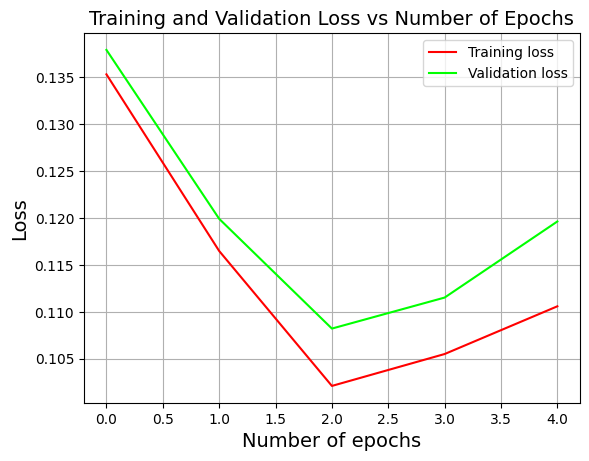

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,▁▃▅▆█
training_acc,▁▅█▇▆
training_loss,█▄▁▂▃
validation cost,█▄▁▂▄
validation_accuracy,▁▆█▇▅
epoch,6
training_acc,0.84656
training_loss,0.11059
validation cost,0.11962
validation_accuracy,0.83117


wandb: Agent Starting Run: 5pw3jo6i with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


mse_lr_0.001_ac_tanh_in_xavier_op_nadam_bs_256_L2_0_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  0.1309430668796107 	Validation cost: 0.13298252376521608
Epoch number : 4
Training cost:  0.11178369165489603 	Validation cost: 0.11552263391671583
Epoch number : 6
Training cost:  0.10192106388455388 	Validation cost: 0.1063064246145775
Epoch number : 8
Training cost:  0.0941182735046407 	Validation cost: 0.09937846471858582
Epoch number : 10
Training cost:  0.08980525222366102 	Validation cost: 0.09606541848225437

Final training cost: 0.08798030732065062


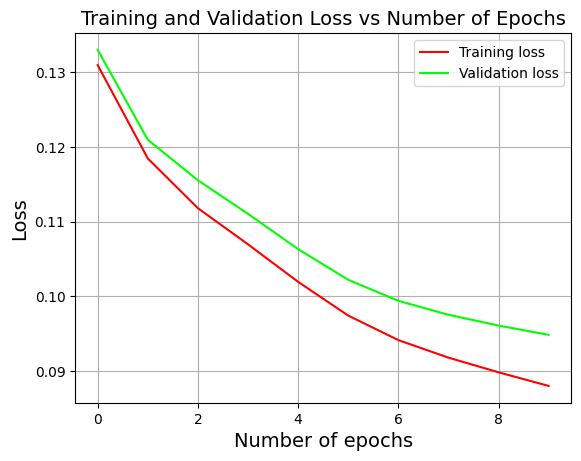

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▃▄▅▆▇▇▇██
training_loss,█▆▅▄▃▃▂▂▁▁
validation cost,█▆▅▄▃▂▂▁▁▁
validation_accuracy,▁▃▄▅▆▇▇███
epoch,11
training_acc,0.87846
training_loss,0.08798
validation cost,0.09483
validation_accuracy,0.8705


wandb: Agent Starting Run: viwfkm6l with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_relu_in_random_normal_op_nestorov_bs_32_L2_0_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 4
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 6
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 8
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 10
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095

Final training cost: 0.44999975593616587


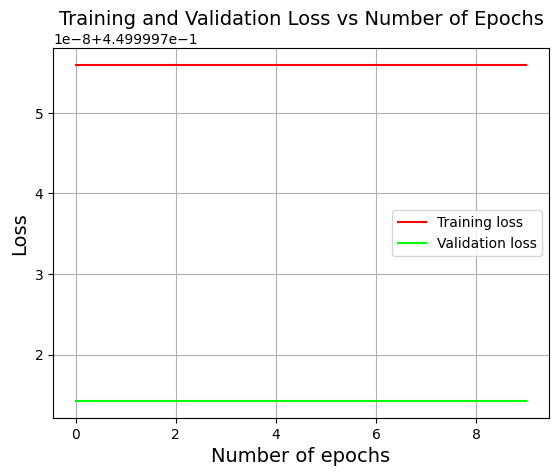

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,11
training_acc,0.09376
training_loss,0.45
validation cost,0.45
validation_accuracy,0.09467


wandb: Agent Starting Run: ihdbb0to with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


mse_lr_0.0001_ac_relu_in_xavier_op_nadam_bs_32_L2_0.0005_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  0.15753563489557024 	Validation cost: 0.16216099648225804
Epoch number : 4
Training cost:  0.11976743396822696 	Validation cost: 0.12440343371424312
Epoch number : 6
Training cost:  nan 	Validation cost: nan

Final training cost: nan


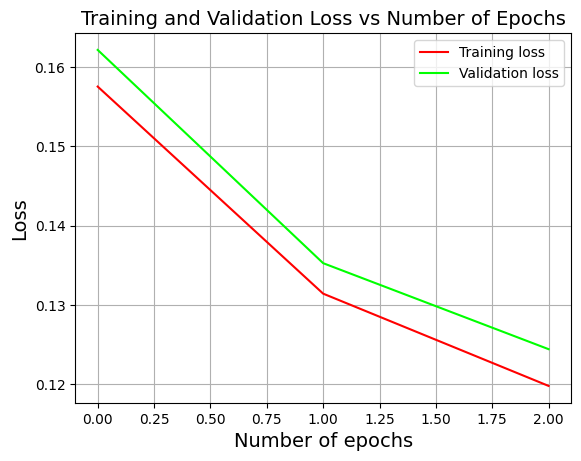

epoch,▁▃▅▆█
training_acc,▇██▁▁
training_loss,█▃▁
validation cost,█▃▁
validation_accuracy,▇██▁▁
epoch,6
training_acc,0.10006
training_loss,nan
validation cost,nan
validation_accuracy,0.0995


wandb: Agent Starting Run: wu15dkpw with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_relu_in_xavier_op_nestorov_bs_256_L2_0.0005_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 4
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 6
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 8
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 10
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 12
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 14
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 16
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 18
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367
Epoch number : 20
Training cost:  0.4522593026884565 	Validation cost: 0.45281221998220367

Final training 

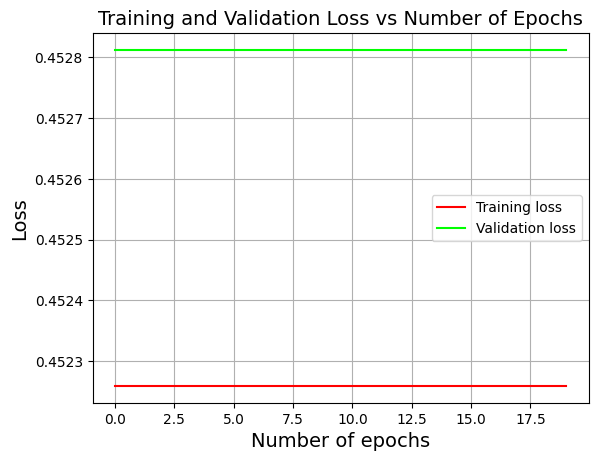

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
training_acc,0.12374
training_loss,0.45226
validation cost,0.45281
validation_accuracy,0.12267


wandb: Agent Starting Run: kuaeb6nx with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_16_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 4
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 6
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 8
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 10
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587

Final training cost: 0.46332896472821467


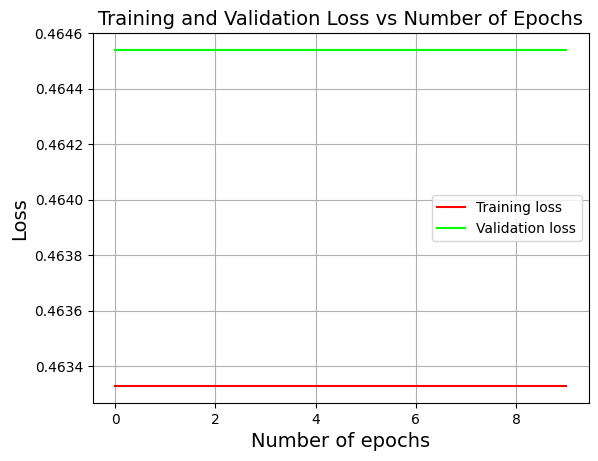

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,11
training_acc,0.11026
training_loss,0.46333
validation cost,0.46454
validation_accuracy,0.10917


wandb: Agent Starting Run: 9fppdeyd with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


mse_lr_0.001_ac_relu_in_xavier_op_nadam_bs_256_L2_0_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  0.17189499075525214 	Validation cost: 0.1774132941934999
Epoch number : 4
Training cost:  0.12800548769983922 	Validation cost: 0.13248618222079592
Epoch number : 6
Training cost:  0.10825435672060217 	Validation cost: 0.1136559035279082
Epoch number : 8
Training cost:  0.09684284469605024 	Validation cost: 0.10301069862812824
Epoch number : 10
Training cost:  0.09269064313341682 	Validation cost: 0.09996224794668762

Final training cost: 0.08871565355397408


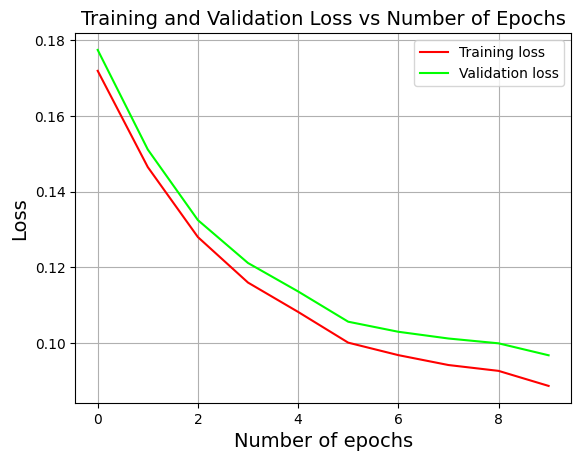

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▃▅▆▆▇▇███
training_loss,█▆▄▃▃▂▂▁▁▁
validation cost,█▆▄▃▂▂▂▁▁▁
validation_accuracy,▁▃▅▆▆▇▇███
epoch,11
training_acc,0.87767
training_loss,0.08872
validation cost,0.0968
validation_accuracy,0.86733


wandb: Agent Starting Run: wlb3pkmm with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


mse_lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_16_L2_0_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  0.11438390891225197 	Validation cost: 0.11717701908689747
Epoch number : 4
Training cost:  0.09624281315140465 	Validation cost: 0.09979587133593303
Epoch number : 6
Training cost:  0.08844138074399438 	Validation cost: 0.09319125239976006
Epoch number : 8
Training cost:  0.08320618268308799 	Validation cost: 0.0896951697740364
Epoch number : 10
Training cost:  0.07945058406568056 	Validation cost: 0.08793833076455326
Epoch number : 12
Training cost:  0.07669944537874444 	Validation cost: 0.08717318570391079
Epoch number : 14
Training cost:  0.07449016785090283 	Validation cost: 0.086832907155038
Epoch number : 16
Training cost:  0.07233268178379938 	Validation cost: 0.08636569855696215
Epoch number : 18
Training cost:  0.06989012566716479 	Validation cost: 0.08547531242243789
Epoch number : 20
Training cost:  0.06731256596706846 	Validation cost: 0.08438231141740361

Final training c

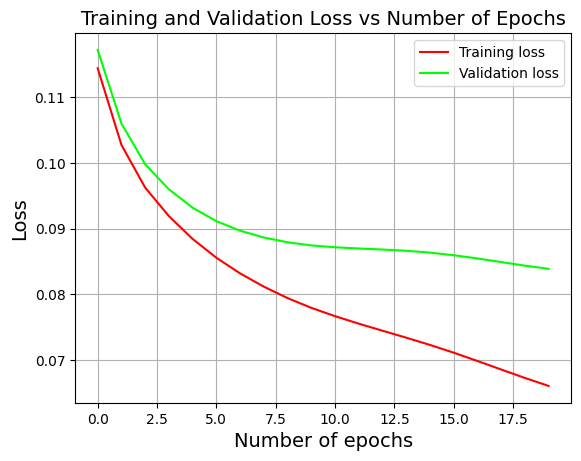

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇████
training_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
validation cost,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇████
epoch,21
training_acc,0.91117
training_loss,0.0661
validation cost,0.0839
validation_accuracy,0.8835


wandb: Agent Starting Run: ce3fjc7k with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_relu_in_random_normal_op_nestorov_bs_256_L2_0_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 4
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 6
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 8
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095
Epoch number : 10
Training cost:  0.44999975593616587 	Validation cost: 0.44999971424112095

Final training cost: 0.44999975593616587


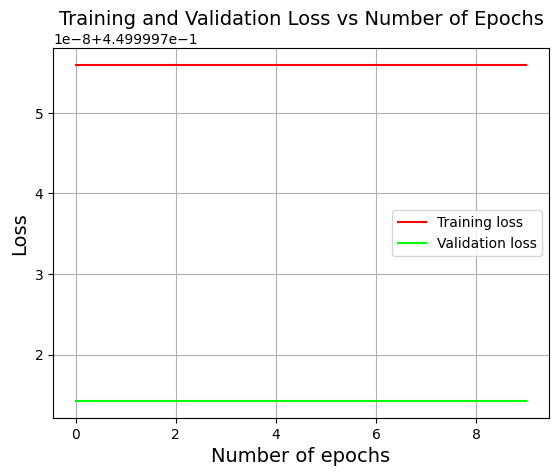

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,11
training_acc,0.09376
training_loss,0.45
validation cost,0.45
validation_accuracy,0.09467


wandb: Agent Starting Run: 0zc6hhzz with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


mse_lr_0.0001_ac_relu_in_random_normal_op_nestorov_bs_16_L2_0.0005_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  0.45000003685640283 	Validation cost: 0.45000061166759925
Epoch number : 4
Training cost:  0.45000003685640283 	Validation cost: 0.45000061166759925
Epoch number : 6
Training cost:  0.45000003685640283 	Validation cost: 0.45000061166759925

Final training cost: 0.45000003685640283


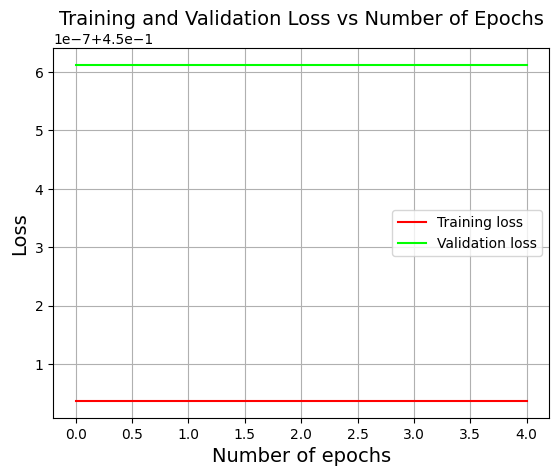

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,6
training_acc,0.10776
training_loss,0.45
validation cost,0.45
validation_accuracy,0.107


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lpi3zx6f with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


mse_lr_0.0001_ac_relu_in_random_normal_op_adam_bs_16_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.44998266329393805 	Validation cost: 0.44998964342393505
Epoch number : 4
Training cost:  0.29011582213062614 	Validation cost: 0.2922628131032803
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan

Final training cost: nan


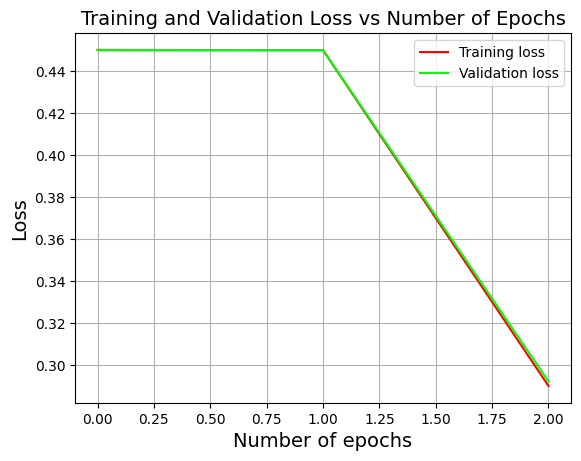

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▃█▁▁▁▁▁▁▁
training_loss,██▁
validation cost,██▁
validation_accuracy,▁▂█▁▁▁▁▁▁▁
epoch,11
training_acc,0.10006
training_loss,nan
validation cost,nan
validation_accuracy,0.0995


wandb: Agent Starting Run: h8emey1n with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_relu_in_random_normal_op_nestorov_bs_256_L2_0.0005_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 4
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 6
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 8
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 10
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801

Final training cost: 0.44999920222395157


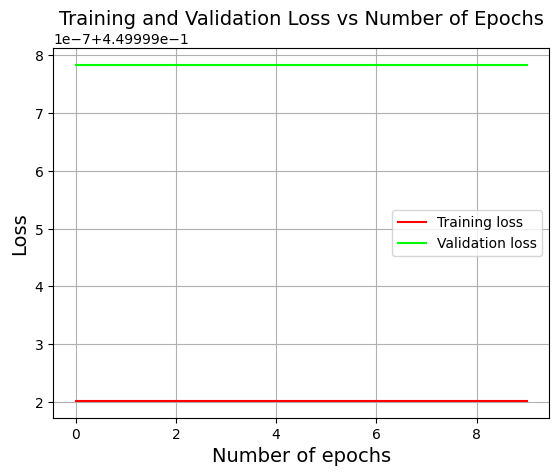

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,11
training_acc,0.12374
training_loss,0.45
validation cost,0.45
validation_accuracy,0.12267


wandb: Agent Starting Run: hg7toro1 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


mse_lr_0.0001_ac_relu_in_xavier_op_nadam_bs_256_L2_0.0005_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  0.24962734884302895 	Validation cost: 0.2534720754215544
Epoch number : 4
Training cost:  0.1756656312541543 	Validation cost: 0.17960230447211994
Epoch number : 6
Training cost:  0.15177931696774088 	Validation cost: 0.15602783644914786

Final training cost: 0.15177931696774088


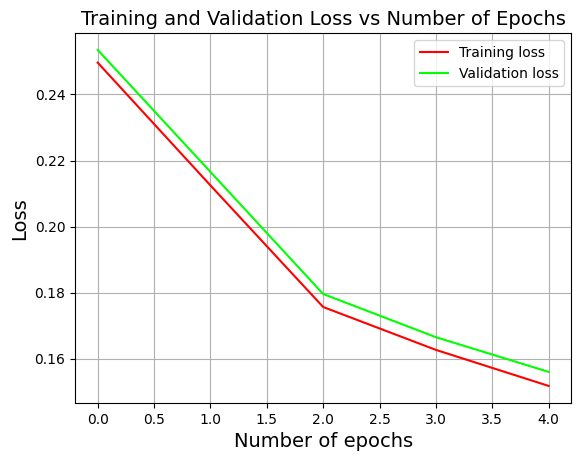

epoch,▁▃▅▆█
training_acc,▁▂▇▇█
training_loss,█▅▃▂▁
validation cost,█▅▃▂▁
validation_accuracy,▁▂▇▇█
epoch,6
training_acc,0.7943
training_loss,0.15178
validation cost,0.15603
validation_accuracy,0.788


wandb: Agent Starting Run: lc3gksmv with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


mse_lr_0.001_ac_relu_in_random_normal_op_nestorov_bs_16_L2_0.0005_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 4
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 6
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 8
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801
Epoch number : 10
Training cost:  0.44999920222395157 	Validation cost: 0.4499997829396801

Final training cost: 0.44999920222395157


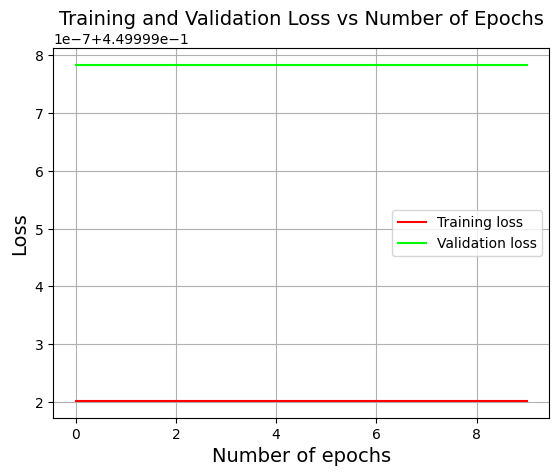

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,11
training_acc,0.12374
training_loss,0.45
validation cost,0.45
validation_accuracy,0.12267


wandb: Agent Starting Run: zq8gbis1 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


mse_lr_0.0001_ac_relu_in_random_normal_op_adam_bs_256_L2_0.0005_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  0.4499998171178843 	Validation cost: 0.4500012721619641
Epoch number : 4
Training cost:  0.4499995552505434 	Validation cost: 0.4500045628546145
Epoch number : 6
Training cost:  0.44999941394345894 	Validation cost: 0.4500074737164941

Final training cost: 0.44999941394345894


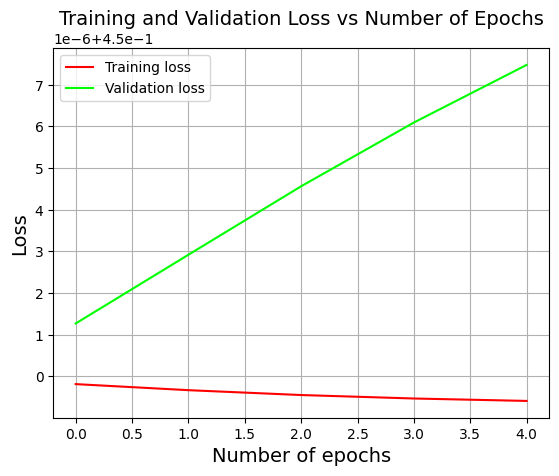

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▅▃▂▁
validation cost,▁▃▅▆█
validation_accuracy,▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation cost,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: s3qeeft1 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


mse_lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_16_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.4499998341119152 	Validation cost: 0.4500068884301309
Epoch number : 4
Training cost:  0.45000063148945785 	Validation cost: 0.4500145429723135
Epoch number : 6
Training cost:  0.45000064630134123 	Validation cost: 0.4500158679416185
Epoch number : 8
Training cost:  0.4500003094242746 	Validation cost: 0.4500157727541867
Epoch number : 10
Training cost:  0.4499997232411493 	Validation cost: 0.4500151841835839
Epoch number : 12
Training cost:  0.4499987593942109 	Validation cost: 0.45001417380851094
Epoch number : 14
Training cost:  0.449996928526156 	Validation cost: 0.4500122708923703
Epoch number : 16
Training cost:  0.4499924430997061 	Validation cost: 0.45000762324762056
Epoch number : 18
Training cost:  0.4499709283737882 	Validation cost: 0.4499856085977268


In [ ]:
sweep_config = {
  "name": "CS6910 Assignment 1 - Squared Error Loss",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["relu", "tanh"]
        },
        "init_mode": {
            "values": ["xavier", "random_normal"]
        },
        "optimizer": {
            "values": ["nestorov", "adam", "nadam"]
        },
        "batch_size": {
            "values": [16,32,256]
        },
        "epochs": {
            "values": [5, 10, 20]
        },
        "L2_lamb": {
            "values": [0, 0.0005]
        },
        "num_neurons": {
            "values": [64, 128]
        },
        "num_hidden": {
            "values": [3, 4]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DA6401-Assignment1")
wandb.agent(sweep_id, NN_fit, count=120)

# Training the model with the best combination of hyperparameters

#### Setting Hyperparameters based on wandb results

These are the best choices for hyperparameters chosen using wandb.ai's sweep feature

In [ ]:
LEARNING_RATE = 0.0001
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "nadam"
BATCH_SIZE = 16
EPOCHS = 20
L2_lambda = 0.0005
NUM_NEURONS = 64
NUM_HIDDEN = 3

LOSS = 'mse'

#### Training on the full dataset

In [ ]:
def NN_best_fit(X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                num_neurons = 64, num_hidden = 3):
    """This function is used to train the neural network on the full dataset given the best set of hyperparameter values

    X_train: numpy array
        train dataset

    y_train_one_hot: numpy array
        train labels with one-hot encoding

    learning_rate: float

    activation_f: string
        activation functions for all the layers except the last layer which is softmax

    init_mode: string
        initialization mode
    
    optimizer: string
        optimization routine

    bach_size: int
        minibatch size

    loss: string
        loss function

    epochs: int
        number of epochs to be used

    L2_lamb: float
        lambda for L2 regularisation of weights

    num_neurons: int
        number of neurons in every hidden layer

    num_hidden: 
        number of hidden layers

    Returns
    -------

    parameters: dict
        weights and biases of the NN model

    epoch_cost: list
        training costs with every epoch
    """
    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2

                # Look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates) # call momentum routine
                
            elif optimizer=='nadam':
                L = len(params)//2

                # Look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t) # call Adam routine

            # # custom optimizer
            # elif optimizer == 'insert your nesterov accelerated optimiser here':
            #     #insert your optimiser here if it uses nesterov accelerated gradients logic

            #     #insert lookahead logic here

            #     #for weight updates, call that optimiser's weight update code here
            #     pass

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

                # #custom
                # elif optimizer == 'insert your optimiser here':
                #     #insert your optimiser update routine only if it does not have nesterov accelerated gradients logic
                #     pass
                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)

        epoch_cost.append(cost)

    
    # Plot the training cost curve
    plt.plot(list(range(len(epoch_cost))), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

    return params, epoch_cost

Epoch number:  2 	Training cost: 0.49185878824697116
Epoch number:  4 	Training cost: 0.4382157921640919
Epoch number:  6 	Training cost: 0.4169785065708766
Epoch number:  8 	Training cost: 0.3948833367563255
Epoch number:  10 	Training cost: 0.379925819407838
Epoch number:  12 	Training cost: 0.3755185413267766
Epoch number:  14 	Training cost: 0.36971823934519277
Epoch number:  16 	Training cost: 0.36967167171598464
Epoch number:  18 	Training cost: 0.3658059726060923
Epoch number:  20 	Training cost: 0.3653852651483509


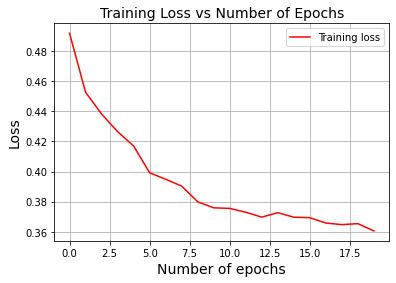

In [ ]:
# One hot encoding for class labels (full training data)
y_one_hot = np.zeros((10, M + Mval))
y_one_hot[y, np.array(list(range(M+Mval)))] = 1

learned_parameters, epoch_cost = NN_best_fit(X, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

#### Model Evaluation with X_test dataset

In [ ]:
train_predictions, test_predictions = NN_evaluate(X, y, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 89.43 %
Test accuracy = 86.71 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.80      0.73      0.76      1000
           3       0.83      0.91      0.87      1000
           4       0.73      0.83      0.78      1000
           5       0.97      0.92      0.94      1000
           6       0.72      0.61      0.66      1000
           7       0.89      0.97      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#### Confusion Matrix (Training set)

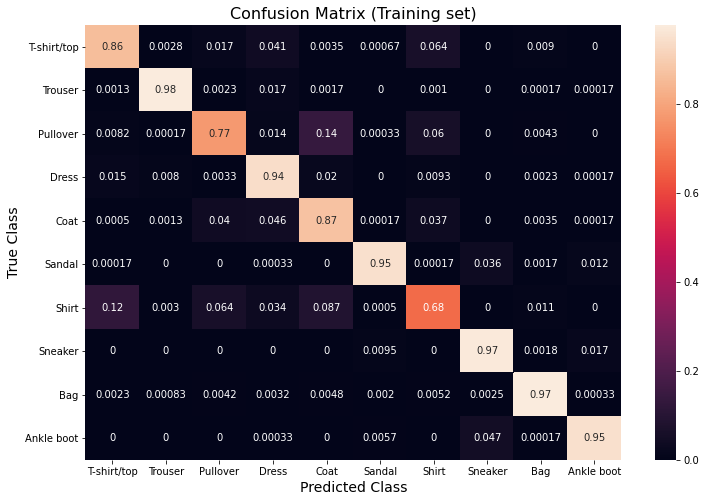

In [ ]:
bern_cnf_matrix_train = confusion_matrix(y, train_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Training set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("trainmatrix")
plt.show()

#### Confusion Matrix (Test set)

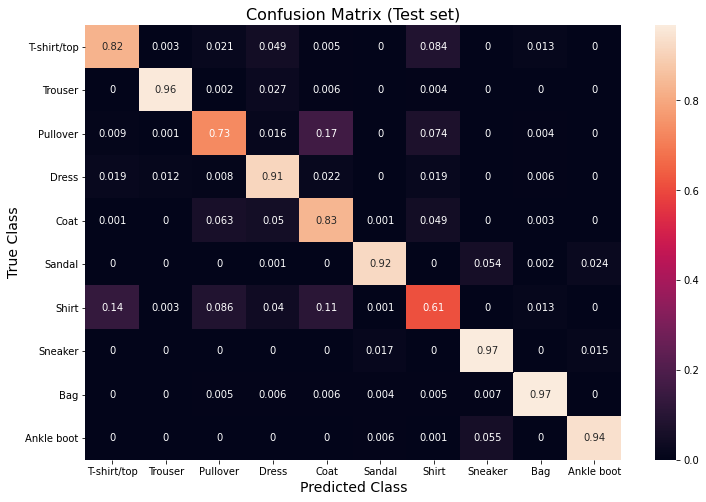

In [ ]:
bern_cnf_matrix_test = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_test, annot=bern_cnf_matrix_test,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("testmatrix")
plt.show()